In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:
def show(images, n_images, nrows, title, n):
  fig_size=[n, n]
  plt.figure(figsize=fig_size)
  grid = make_grid(((images + 1) / 2).detach().cpu()[:n_images], nrow=nrows).permute(1,2,0).squeeze()
  plt.title(title)
  plt.imshow(grid)
  plt.show()

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [4]:
dataset = torchvision.datasets.Flowers102('C:/Users/hosei/Documents/torch-data/', split='test',
                  transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=64,
                         shuffle=True)

c:\Users\hosei\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
for i, image in enumerate(data_loader):
  img = image[0]

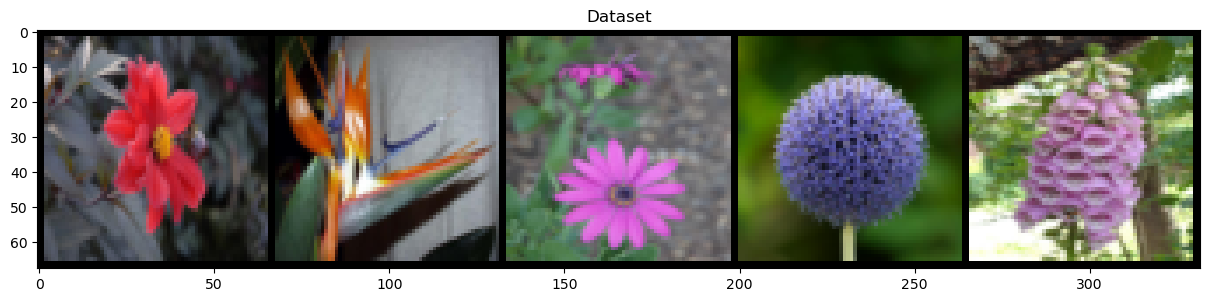

In [6]:
show(img, 25, 5, title='Dataset',n=15)

In [7]:
def generator_block(input, output, kernel_size=3, padding=1, last_layer=False, bias=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, padding, bias=bias),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, padding, bias=bias),
        nn.Tanh()
    )
  return x

In [8]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.generator = nn.Sequential(
        generator_block(noise_dim, hidden_dim * 8, kernel_size=3, padding=1),
        generator_block(hidden_dim * 8, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 2),
        generator_block(hidden_dim * 2, hidden_dim),
        generator_block(hidden_dim, image_dim, last_layer=True)
    )

  def forward(self, noise):
    noise = noise.view(len(noise), self.noise_dim, 1, 1)
    return self.generator(noise)

In [9]:
def get_noise_vectors(n_samples, noise_dim, device='cpu'):
  return torch.randn(n_samples, noise_dim, device=device)

In [10]:
def discriminator_block(input, output, kernel_size=3, padding=1, last_layer=False, bias=False):
  if not last_layer:
    x = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(input, output, kernel_size, padding, bias=bias)),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(input, output, kernel_size, padding, bias=bias)),
        nn.Sigmoid()
    )
  return x

In [11]:
class Discriminator(nn.Module):
  def __init__(self, image_dim, hidden_dim):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
        discriminator_block(image_dim, hidden_dim),
        discriminator_block(hidden_dim, hidden_dim * 2),
        discriminator_block(hidden_dim * 2, hidden_dim * 4),
        discriminator_block(hidden_dim * 4, hidden_dim * 8,),
        discriminator_block(hidden_dim * 8, 1, padding=1, last_layer=True)
    )
  def forward(self, image):
    x = self.discr(image)
    return x.view(len(x), -1)

In [12]:
criterion = nn.BCELoss()
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
noise_dim = 64

# image configs
image_channels = 3
hidden_dim_gen = 64
hidden_dim_discr = 64

epochs = 200
batch_size=128
step = 500
device = 'cuda'

In [13]:
def init_weights(layer):
  if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
    nn.init.normal_(layer.weight, 0.0, 0.02)
  if isinstance(layer, nn.BatchNorm2d):
    nn.init.normal_(layer.weight, 1.0, 0.02)
    nn.init.constant_(layer.bias, 0)

generator = Generator(noise_dim, image_channels, hidden_dim_gen).to(device)
generator.cuda()
gen_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
discriminator = Discriminator(image_channels, hidden_dim_discr).to(device)
discriminator.cuda()
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

generator = generator.apply(init_weights)
discriminator = discriminator.apply(init_weights)

In [1]:
gen_losses = 0
disc_losses = 0
lst_gen_losses = []
lst_disc_losses = []
cur_iter = 0

for epoch in range(epochs):
  for image, _ in tqdm(data_loader):
    cur_batch_size = len(image)
    image = image.to(device)

    # Discriminator Update
    disc_optim.zero_grad()
    output = discriminator(image)
    real_loss_D = criterion(output, torch.ones_like(output))
    real_loss_D.backward()

    fake_noise = get_noise_vectors(cur_batch_size, noise_dim, device=device)
    fake = generator(fake_noise)
    output = discriminator(fake.detach())
    fake_loss_D = criterion(output, torch.zeros_like(output))
    disc_loss = (real_loss_D + fake_loss_D) / 2
    disc_losses += disc_loss.item() / step
    lst_disc_losses += [disc_losses]
    fake_loss_D.backward()
    disc_optim.step()

    # Generator Update
    gen_optim.zero_grad()
    output = discriminator(fake)
    loss_G = criterion(output, torch.ones_like(output))
    loss_G.backward()
    gen_optim.step()
    gen_losses += loss_G.item() / step
    lst_gen_losses += [gen_losses]
    

    # Progress and Visualization
    
  print("Epoch {}\nGenerator Loss: {}\nDiscr Loss: {}".format(epoch, gen_losses, disc_losses))
  fake = generator(fake_noise)
  show(fake, 25, 5, title='Fake' , n=5)
  # show(image, 25, 5, title='Real' , n=5)
  disc_losses = 0
  gen_losses = 0

NameError: name 'epochs' is not defined

In [16]:
torch.save(generator.state_dict(), 'gen_weights.pth')
torch.save(discriminator.state_dict(), 'disc_weights.pth')

In [17]:
generator.eval()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): C

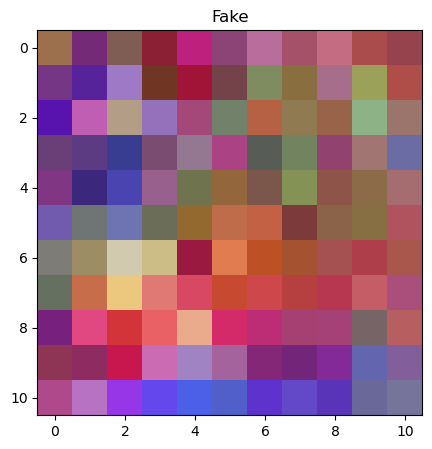

In [20]:
new_noise = get_noise_vectors(1, 64, device=device)
generated = generator(new_noise)
show(generated, 1, 1, 'Fake', 5)

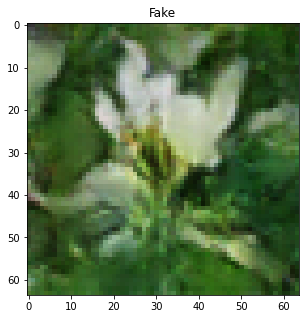

In [ ]:
new_noise = get_noise_vectors(1, 64, device=device)
generated = generator(new_noise)
show(generated, 1, 1, 'Fake', 5)